In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns

from migrator import *
from plotter import *
from co2_migrator import *

In [2]:
!pip install tabulate
!pip install seaborn

In [3]:
metamodels = []
metamodels_with_migrations = []
SCALE_TO_MARCONI = 2982 / 150
for file in os.listdir("metamodels"):
    country_code = file[:2]
    if country_code == "EU":
        country_code = file[:6]
        metamodels_with_migrations.append(
            MetaModel(
                country_code=country_code,
                co2_emissions=pd.read_parquet("metamodels/" + file)["carbon_emission"].values
            )
        )
        continue

    metamodels.append(
        MetaModel(
            country_code=country_code,
            co2_emissions=pd.read_parquet("metamodels/" + file)["carbon_emission"].values
        )
    )

for metamodel in metamodels:
    metamodel.total_emissions *= SCALE_TO_MARCONI  # to the scale of marconi, data represented in tons


In [4]:
data = [(metamodel.country_code, metamodel.total_emissions) for metamodel in metamodels]

countries = [metamodel.country_code for metamodel in metamodels]
total_co2 = [metamodel.total_emissions for metamodel in metamodels] # emissions in tons of CO2

print("Country \t Total tCO2")
for metamodel in metamodels:
    print(f"{metamodel.country_code:<15}{metamodel.total_emissions:>0.2f}")

Country 	 Total tCO2
DK             1.65
HU             6.60
SE             0.10
BA             7.40
CH             0.08
IT             1.53
RS             6.18
RO             2.19
GR             1.98
FR             0.22
PT             0.83
LV             0.49
BG             2.49
DE             13.40
EE             3.22
NL             4.20
AT             0.65
HR             1.56
SK             0.73
MK             8.83
CZ             3.53
PL             7.37
FI             0.18
LU             0.78
NO             0.10
ES             3.74
LT             1.03
BE             0.72
SI             2.97


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


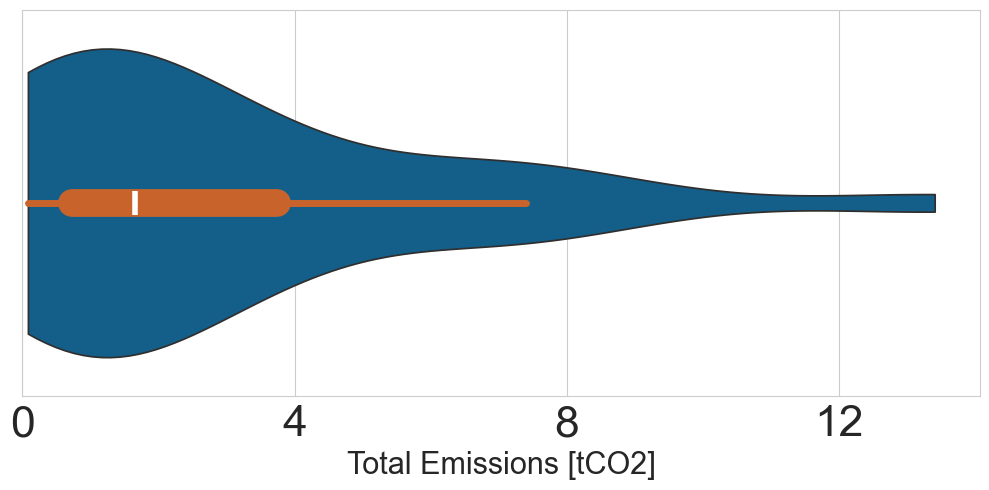

In [20]:
# Create a DataFrame from the metamodel data
data = pd.DataFrame({
    'Country': [metamodel.country_code for metamodel in metamodels],
    'Total CO2': [metamodel.total_emissions for metamodel in metamodels]
})
plt.figure(figsize=(10, 5))
sns.violinplot(
    data=data,
    x=total_co2,
    inner_kws=dict(box_width=20, whis_width=5, color='#C8642B'),
    color='#00649D',
    # minimum of x is 0
    density_norm='width',
    cut=0
)
plt.xlabel('Total Emissions [tCO2]', fontsize=22)
plt.xlim(0, None)
plt.xticks(fontsize=32, ticks=[0, 4, 8, 12])

# save the plot with tight layout
plt.tight_layout()
plt.savefig('violin-plot.pdf')


In [5]:
# find the lowest 5 emissions, summed up, for the EU, then compare using a horizontal bar char
# CO2 emissions for migration of 15 min, 1h, ... vs the lowest 5 consumers
lowest_8_emissions = []

all_metamodels = metamodels + metamodels_with_migrations

for metamodel in metamodels_with_migrations:
    # append the total emissions and the country code
    lowest_8_emissions.append((metamodel.total_emissions, metamodel.country_code))

for metamodel in metamodels:
    # append the total emissions and the country code
    lowest_8_emissions.append((round((metamodel.total_emissions),2), metamodel.country_code))


# sort the emissions in ascending order
lowest_8_emissions.sort(key=lambda x: x[0])
lowest_8_emissions[:8]

[(3.66, 'EU-15m'),
 (3.66, 'EU-1h.'),
 (3.78, 'EU-4h.'),
 (4.16, 'EU-8h.'),
 (7.09, 'EU-24h'),
 (81.31, 'CH'),
 (99.2, 'SE'),
 (103.77, 'NO')]

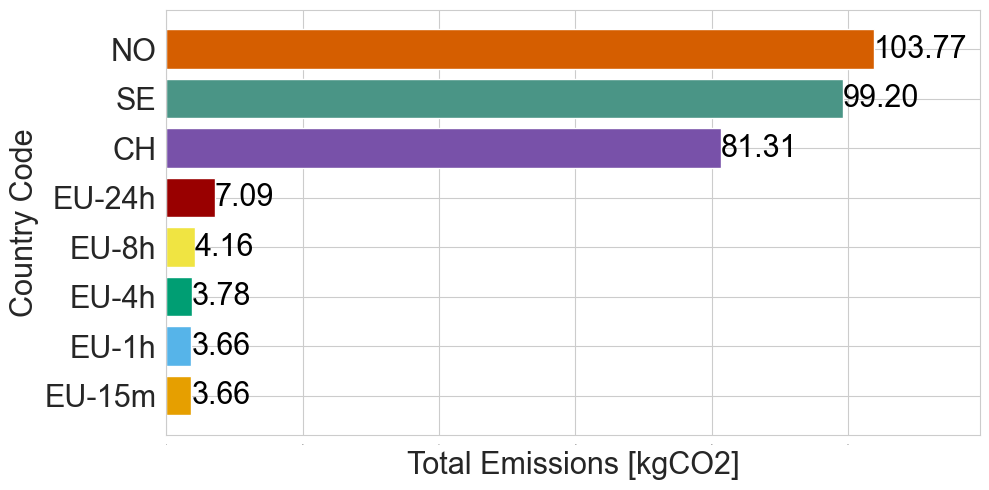

In [6]:
# plot as a horizontal bar chart
plt.figure(figsize=(10, 5))

colorblind_friendly_colors_copy = [
    "#E69F00",  # orange
    "#56B4E9",  # sky blue
    "#009E73",  # bluish green
    "#F0E442",  # yellow
    "#990000",  # dark red
    "#7851A9",  # royal purple
    "#4A9586",  # blue green
    "#D55E00",  # vermilion
]

countries = [x[1] for x in lowest_8_emissions[:8]]
countries = ["EU-15m", "EU-1h", "EU-4h", "EU-8h", "EU-24h", "CH", "SE","NO"]
emissions = [x[0] for x in lowest_8_emissions[:8]]
colors = colorblind_friendly_colors_copy[:8]

bars = plt.barh(countries, emissions, color=colors)
plt.xlabel('Total Emissions [kgCO2]', fontsize=22)
plt.xlim(0, max(emissions) * 1.15)
plt.yticks(fontsize=22)  # Adjusted for better visibility and fit
plt.ylabel('Country Code', fontsize=22)
plt.xticks(fontsize=0)  # Adjusted for better visibility and fit

# Adding text labels to the bars
for bar, emission in zip(bars, emissions):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{emission:.2f}',
             va='center', ha='left', fontsize=22, color='black')

plt.tight_layout()
plt.savefig("exp3-lowest-8-emissions.pdf")